# CaixaBank Tech Hackathon - Lydia Petridi

## Librerías

In [326]:
!pip install emoji
!pip install textblob
!pip install tqdm
!pip install spanish_sentiment_analysis

In [327]:
# Dataframes
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt



#NLP
import nltk
from string import punctuation
import re
import emoji
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk import word_tokenize
import unicodedata


#Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix



#Red Neuronal
import tensorflow as tf
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.utils import class_weight



#Barra de progreso
from tqdm import tqdm

## Ficheros y archivos

In [328]:
nltk.download('stopwords')

STOP_WORDS = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Λυδία\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [329]:
PATH = "data/"

FILE_TRAIN = "train.csv"
FILE_TWEETS = "tweets_from2015_#Ibex35.csv"
FILE_TEST = "test_x.csv"

## Funciones

In [330]:
def duplicates(df):
    
    # Función que permite contar los duplicados tanto en cantidad absoluta, como en relación con el total de registros
    # Argumentos: (df): dataframe
    
    d = df.duplicated().sum()
    t = len(df.index)
    porcentaje_duplicados = d/t * 100
    print ("- Total entries:", t, " -Duplicated entries:", d, " - Percentage:", porcentaje_duplicados,"%")
    
    
    
def columns_with_all_zeroes(df):     
    
    # Función que permite ver si hay cualquier columna en un dataframe que tenga todos los valores zero
    # Argumentos: (df): dataframe
    
    for column_name in df.columns:
        if (df[column_name] == 0).all():
            print("Column '",column_name, "' HAS ONLY ZEROS")
        else:
            print("Column '",column_name,"' contains other values")
            
#########################################################################################################


### NLP

def remove_accents(input_str):
    
    # Quitar acentos
    # Argumentos: (input_str): string
    
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii

            
            
def one_space_reduction(text):
    
    # Reducir múltiples espacios en blanco a uno solo
    # Argumentos: (text): string
    
    output_text =  re.sub(' +', ' ', text)
    return output_text


def delete_tabs_newlines(text):
    
    # Eliminar la existencia de whitespaces, nuevas lineas y tabs
    # Argumentos: (text): string
    
    output_text = re.sub('\s+',' ',text)
    return output_text

def delete_url(text):
    
    # Eliminar la existencia de enlaces
    # Argumentos: (text): string
    
    output_text = re.sub(r"\S*https?:\S*", "", text)
    return output_text


def clean_hashtag(text):
    
    # Convertir los hashtags en palabras
    # Argumentos: (text): string
    
    output_text = " ".join(word.strip() for word in re.split('#|_', text))
    return output_text


def convert_emojis(text):
        
    # Convertir los emojis en palabras
    # Argumentos: (text): string
    
    output_text = emoji.demojize(text)
    return output_text


def lower_case(text):
    
    # Convertir el texto en minusculas
    # Argumentos: (text): string
    
    output_text = text.lower()
    return output_text



def delete_punctuation_I(text):
    
    # Quitar signos de puntuación
    # Argumentos: (text): string
    
    output_text = re.sub('[^-9A-Za-z ]', '', text)
    return output_text


def delete_stop_words(text):
    STOP_WORDS = set(stopwords.words('english'))
    output_words = [word for word in text.split() if word not in STOP_WORDS]
    output_text = ' '.join(output_words)
    return output_text


def text_cleaning(text):
    
    # Definir una función que ejecute todas las transformaciones de texto anteriores
    # Argumentos: (text): string
    
    transformed_text = delete_url(text)
    transformed_text = clean_hashtag(transformed_text)
    transformed_text = convert_emojis(transformed_text)
    transformed_text = delete_stop_words(transformed_text)
    transformed_text = lower_case(transformed_text)
    transformed_text = delete_tabs_newlines(transformed_text)
    transformed_text = delete_punctuation_I(transformed_text)    
    output_text = one_space_reduction(transformed_text)
    return(output_text)



def get_tweet_sentiment(tweet):
        analysis = TextBlob(clean_tweet(tweet))
        language = analysis.detect_language()
        if language == 'en':
            analysis_ready = analysis
        else:
            analysis_ready = analysis.translate(to='en')
            
        if analysis_ready.sentiment.polarity > 0: 
            return 'positive'
        elif analysis_ready.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'

#####################################################################################################

## Subjectivity - Polatity



def getSubjectivity(review):

    # Función que calcula la subjetividad de un texto
    # Argumentos: (review): string
    
    return TextBlob(review).sentiment.subjectivity



def getPolarity(review):
    
    # Función que calcula la polaridad de un texto
    # Argumentos: (review): string
    
    return TextBlob(review).sentiment.polarity



## Carga de los datasets

In [331]:
pd.set_option('display.max_colwidth', None)         #Enseñar todo el contenido de las celdas

In [332]:
df_train_raw = pd.read_csv(PATH+FILE_TRAIN)
df_tweets_raw = pd.read_csv(PATH+FILE_TWEETS)
df_test_raw = pd.read_csv(PATH+FILE_TEST)

Visualizando los 15 primeros y últimos registros de cada dataframe para comprobar su carga correcta y las fechas a las que se refiere cada uno

In [333]:
df_train_raw.head(15)

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
5,1994-01-10,3655.199951,3678.199951,3655.199951,3660.600098,3660.596436,0.0,1
6,1994-01-11,3679.699951,3712.500000,3679.699951,3712.399902,3712.396240,0.0,1
7,1994-01-12,3712.300049,3712.300049,3675.899902,3680.100098,3680.096436,0.0,1
8,1994-01-13,3680.100098,3698.199951,3670.399902,3680.800049,3680.796387,0.0,1
9,1994-01-14,3680.800049,3737.399902,3662.899902,3736.399902,3736.395996,0.0,1


In [334]:
df_train_raw.tail(15)

,Date,Open,High,Low,Close,Adj Close,Volume,Target
6539,2019-05-10,9149.400391,9179.400391,9099.099609,9117.500000,9117.500000,147760300.0,1
6540,2019-05-13,9127.599609,9127.599609,9025.700195,9046.799805,9046.799805,147442300.0,1
6541,2019-05-14,9078.200195,9127.599609,9053.599609,9127.599609,9127.599609,139675700.0,1
6542,2019-05-15,9143.000000,9177.099609,9061.900391,9177.099609,9177.099609,143425500.0,1
6543,2019-05-16,9161.400391,9304.299805,9136.700195,9304.299805,9304.299805,157566000.0,0
6544,2019-05-17,9278.700195,9321.599609,9223.099609,9280.099609,9280.099609,159798300.0,0
6545,2019-05-20,9286.000000,9334.900391,9177.900391,9199.700195,9199.700195,153317000.0,0
6546,2019-05-21,9229.000000,9255.000000,9185.200195,9239.099609,9239.099609,131576400.0,0
6547,2019-05-22,9232.299805,9288.700195,9182.500000,9232.200195,9232.200195,146552900.0,0
6548,2019-05-23,9170.700195,9186.700195,9098.400391,9114.000000,9114.000000,161094300.0,1


In [335]:
df_tweets_raw.head(15)

,tweetDate,handle,text
0,Sat Apr 09 14:47:45 +0000 2022,abelac62,"He hecho el repaso de todos los componentes del #IBEX35 y ahora me pongo con lo de La Chiqui. Si mañana tengo tiempo, publicaré algún activo interesante del mercado europeo y americano. Buen fin de semana."
1,Thu Apr 07 19:14:36 +0000 2022,LluisPerarnau,"Els projectes que han presentat les empreses del #Ibex35 als fons #NextGenerationEU: \nEndesa 110 projectes, 19.000 M €\nIberdrola 150 projectes, 21.000 M\nNaturgy 13.000 M\nACS 4.500 M\n...i així fins a sumar 100.000 M € per als grups oligàrquics de sempre."
2,Mon Apr 04 16:48:45 +0000 2022,Pegaso121080,"Por si no lo has visto, o no lo encuentras en búsquedas que suele pasar 🤔\n#Analisis y niveles del #Ibex35 y varias #Acciones en #Youtube \n#Ezentis #AedasHomes #LLeidanet #Merlinpropertis #BBVA y otras muchas en el canal 🧐\n🙏Espero que guste y/o ayude 🔄\nhttps://t.co/6yqA0TbRJY"
3,Tue Apr 05 07:23:16 +0000 2022,zonavalue,"📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 🔼 +0,10% (8.527,8 puntos)\n\nMayores subidas\n#Aena 🔼+1,40%\n#SiemensGamesa 🔼+1,07%\n#Cellnex 🔼+0,86% https://t.co/LxHqCPzPtP"
4,Thu Mar 31 16:07:43 +0000 2022,EPeconomia,"El #Ibex35 retrocede un 0,4% en marzo y un 3,08% en el primer trimestre de 2022\nhttps://t.co/wSm71JLkOr https://t.co/fttYtU1p0k"
5,Fri Apr 08 07:44:03 +0000 2022,IndraCompany,Repetimos un año más como la mejor compañía del #Ibex35 en la que trabajar y la segunda en España en el #LinkedInTopCompanies 2022. \nVía @CincoDiascom https://t.co/6J2d60quFW
6,Tue Apr 05 20:30:47 +0000 2022,Bolsacarlosmari,"#Ibex35 se agota el margen para subir, cuidado que el resto de los mercados tienen señales de caídas como así han empezado hoy. https://t.co/Q72aXubaG0"
7,Fri Apr 08 18:15:19 +0000 2022,Bolsacarlosmari,"#Ibex35 con el sentimiento negativo que hay, los mercados no caen y al menos, el nuestro tiene margen para subir, velas semanales. https://t.co/ZEq7L60L7k"
8,Thu Mar 31 14:57:52 +0000 2022,CAPITALRADIOB,🔴 ANÁLISIS | También hemos dejado un hueco a la última hora del #IBEX35\n\n➡️ Con @juanestevee de @kaumarkets \n\n 🎙 Aquí te dejamos su análisis 👉 https://t.co/QiGi6vTkMA https://t.co/10rUIyXJt8
9,Wed Mar 16 17:39:15 +0000 2022,Tanyada_Ed,"🌿 ""Dels FLA als Next Genration: Recrudescència de la recentralització estatal contra els Països Catalans"" altre cop de la mà d'@ivallets, per entendre en profunditat el paper dels fons en la reestructuració del capitalisme i el centralisme."


In [336]:
df_tweets_raw.tail(15)

,tweetDate,handle,text
9786,Thu Jan 08 16:43:53 +0000 2015,Cotizalia,"El #ibex35 cierra con una subida del 2,26%, hasta 10.115 puntos"
9787,Tue Jan 06 19:29:59 +0000 2015,fraudeF,"Los dueños del #Ibex35 son 27.168 millones más ricos que hace un año. No es una crisis, es una estafa. http://t.co/XPTvXNdnhX"
9788,Mon Jan 05 08:29:46 +0000 2015,elEconomistaes,"Tras un arranque en negativo, el #Ibex35 retoma las subidas sobre los 10.300 puntos http://t.co/hb0kVBvC6U"
9789,Sun Jan 04 17:59:45 +0000 2015,jcarlos_ortega,.@monicamelle escasamente entusiasta sobre el 2015: «La recuperación la percibirán tan solo las empresas del #ibex35 «http://t.co/j94rVwN8UL
9790,Sat Jan 10 10:35:36 +0000 2015,newsontuiter,"El peor día del #Ibex35 desde septiembre de 2012: cae un 3,9% lastrado por el #BancoSantander http://t.co/VwraCUU0gS"
9791,Mon Jan 05 12:48:29 +0000 2015,Alterinver,Evolución de los valores del Ibex35 en 2014. Gainers Vs. Losers: http://t.co/sxIkdH9WmX #ibex35 #bolsa #inversion
9792,Mon Jan 05 16:38:25 +0000 2015,elEconomistaes,"#Cierre | El #Ibex35 se hunde el 3,45% hasta los 9.993,3 puntos http://t.co/1ucQyqdGxz"
9793,Tue Jan 06 22:12:04 +0000 2015,Fredy_Rotonda,"#IBEX35 El macd diario se corta por debajo de cero, generando la tipica señal de venta...Buenas noches que descansen http://t.co/XFyjuwXO5m"
9794,Sat Jan 10 15:03:46 +0000 2015,GestiBolsa,#IBEX35 Los mínimos del pasado mes de diciembre han funcionado como zona de soporte a las fortísimas caídas de ayer: http://t.co/Pp81ZMCb1e
9795,Tue Jan 06 08:57:25 +0000 2015,manelmarquez,Tomad capitalismo! #España Los dueños del #Ibex35 son 27.168 millones más ricos q hace un año http://t.co/so1wJNLZiZ http://t.co/H2ka8VDWM1


In [337]:
df_test_raw.head(15)

,test_index,Date,Open,High,Low,Close,Adj Close,Volume
0,6557,2019-06-05,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0
1,6558,2019-06-06,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0
2,6559,2019-06-07,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0
3,6560,2019-06-10,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0
4,6561,2019-06-11,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0
5,6562,2019-06-12,9244.400391,9274.599609,9223.099609,9238.500000,9238.500000,145203300.0
6,6563,2019-06-13,9227.599609,9301.700195,9208.799805,9247.099609,9247.099609,126134300.0
7,6564,2019-06-14,9233.799805,9244.700195,9169.299805,9194.200195,9194.200195,114978600.0
8,6565,2019-06-17,9199.599609,9205.099609,9127.900391,9131.700195,9131.700195,118121500.0
9,6566,2019-06-18,9112.900391,9253.400391,9060.400391,9240.700195,9240.700195,200005900.0


In [338]:
df_test_raw.tail(15)

,test_index,Date,Open,High,Low,Close,Adj Close,Volume
711,7268,2022-03-11,8115.299805,8375.299805,8068.100098,8142.100098,8142.100098,333210300.0
712,7269,2022-03-14,8228.900391,8313.400391,8190.299805,8234.400391,8234.400391,236741400.0
713,7270,2022-03-15,8150.200195,8286.700195,8092.700195,8236.099609,8236.099609,238010100.0
714,7271,2022-03-16,8375.700195,8475.500000,8324.599609,8380.400391,8380.400391,331698500.0
715,7272,2022-03-17,8409.500000,8445.799805,8317.400391,8412.000000,8412.000000,243534800.0
716,7273,2022-03-18,8422.400391,8434.099609,8309.200195,8417.599609,8417.599609,336645800.0
717,7274,2022-03-21,8417.299805,8465.599609,8389.200195,8389.200195,8389.200195,149776400.0
718,7275,2022-03-22,8415.700195,8487.200195,8400.700195,8487.200195,8487.200195,176349800.0
719,7276,2022-03-23,8509.599609,8522.200195,8328.400391,8328.400391,8328.400391,184043600.0
720,7277,2022-03-24,8352.099609,8380.000000,8274.500000,8305.099609,8305.099609,175543500.0


## Exploración y Transformación de los datos

### Train dataset

In [339]:
df_train_raw.info() 

# así podemos ver brevemente la cantidad de registros, la existencia de nulos y el tipo de los datos 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6554 entries, 0 to 6553
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6554 non-null   object 
 1   Open       6421 non-null   float64
 2   High       6421 non-null   float64
 3   Low        6421 non-null   float64
 4   Close      6421 non-null   float64
 5   Adj Close  6421 non-null   float64
 6   Volume     6421 non-null   float64
 7   Target     6554 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 409.8+ KB


Primeros insights: tratar los valores nulos

In [340]:
df_train_raw.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1


In [341]:
# Sobre los valores nulos, se decide rellenarlos con los valores del registro anterior (Backfill)

df_train_raw = df_train_raw.bfill()

In [342]:
df_train_raw.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,1994-01-06,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,0
4,1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1


In [343]:
df_train_raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6554 entries, 0 to 6553
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6554 non-null   object 
 1   Open       6554 non-null   float64
 2   High       6554 non-null   float64
 3   Low        6554 non-null   float64
 4   Close      6554 non-null   float64
 5   Adj Close  6554 non-null   float64
 6   Volume     6554 non-null   float64
 7   Target     6554 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 409.8+ KB


In [344]:
# Ahora que los nulos no son problema, comprobamos las características estadísticas del dataframe
# Eso nos permitirá saber si se podría necesitar o no normalización de los datos


df_train_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,6554.0,8.903816e+03,2.741805e+03,2865.100098,7674.099854,9307.300293,1.051323e+04,1.599920e+04
High,6554.0,8.972739e+03,2.759171e+03,2877.300049,7745.699829,9378.350098,1.058118e+04,1.604040e+04
Low,6554.0,8.826116e+03,2.722110e+03,2833.600098,7582.249878,9219.699707,1.042920e+04,1.586860e+04
Close,6554.0,8.902922e+03,2.740826e+03,2865.100098,7667.250000,9305.149903,1.050668e+04,1.594570e+04
Adj Close,6554.0,8.902914e+03,2.740824e+03,2865.097168,7667.242188,9305.149903,1.050666e+04,1.594568e+04
Volume,6554.0,8.059620e+07,1.224941e+08,0.000000,0.000000,192100.000000,1.737833e+08,7.894902e+08
Target,6554.0,5.169362e-01,4.997512e-01,0.000000,0.000000,1.000000,1.000000e+00,1.000000e+00


In [345]:
# Comprobando que no existen duplicados:

duplicates(df_train_raw)

- Total entries: 6554  -Duplicated entries: 0  - Percentage: 0.0 %


In [346]:
# Viendo solo 0 en los primeros registros por el atributo "Volume", vamos a ver si existen otros valores

columns_with_all_zeroes(df_train_raw)

Column ' Date ' contains other values
Column ' Open ' contains other values
Column ' High ' contains other values
Column ' Low ' contains other values
Column ' Close ' contains other values
Column ' Adj Close ' contains other values
Column ' Volume ' contains other values
Column ' Target ' contains other values


Aunque la columna "volume" no tiene solo ceros, tener muchos registros con ese valor podría perjudicar el rendimiento del modelo. Por tanto, se va a contar la cantidad de registros donde el volumen de acciones negociadas es 0.

In [347]:
print("Cantidad de 0s en la columna 'Volume':", (df_train_raw['Volume'] == 0).sum())
print("Total de registros:", len(df_train_raw))

Cantidad de 0s en la columna 'Volume': 1726
Total de registros: 6554


La cantidad anterior es importante, por tanto se decide eliminar esos registros: 

In [348]:
df_train_raw = df_train_raw[df_train_raw['Volume'] != 0]
print("Nuevo total de registros:", len(df_train_raw))
df_train_raw.head(15)

Nuevo total de registros: 4828


,Date,Open,High,Low,Close,Adj Close,Volume,Target
1710,2000-07-24,10879.599609,10924.400391,10812.500000,10831.500000,10831.489258,5545600.0,0
1711,2000-07-25,10831.500000,10842.200195,10703.400391,10714.599609,10714.588867,7368000.0,0
1712,2000-07-26,10722.599609,10840.200195,10722.599609,10743.799805,10743.789063,6643800.0,0
1713,2000-07-27,10743.799805,10856.599609,10713.400391,10726.000000,10725.989258,6989400.0,0
1714,2000-07-28,10726.000000,10735.000000,10526.799805,10560.000000,10559.989258,6670000.0,1
1715,2000-07-31,10560.000000,10584.700195,10375.000000,10531.599609,10531.588867,7334200.0,0
1716,2000-08-01,10531.599609,10591.299805,10481.099609,10549.000000,10548.989258,6354300.0,1
1717,2000-08-02,10549.000000,10656.099609,10522.799805,10644.500000,10644.489258,7650100.0,1
1718,2000-08-03,10644.500000,10645.700195,10453.000000,10453.000000,10452.989258,7487500.0,1
1719,2000-08-04,10517.900391,10610.099609,10517.900391,10583.400391,10583.389648,6189300.0,1


#### Matriz de Correlación

Por la naturaleza del problema, se espera que habrán altas correlaciones entre los atributos.

Text(0.5, 1.0, 'Matriz de Correlación por el dataframe "Train_raw"')

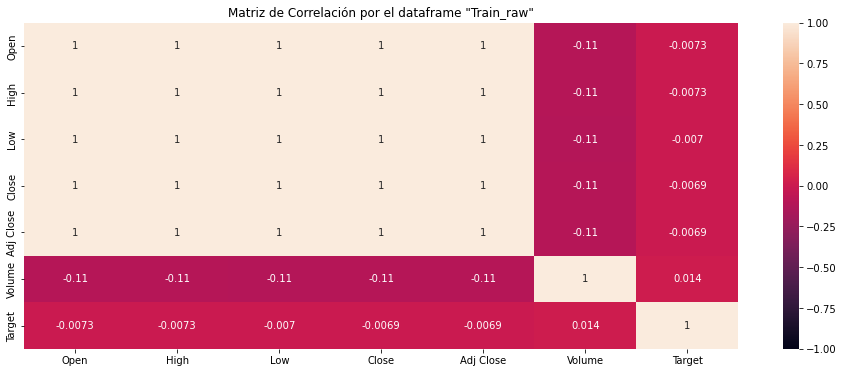

In [349]:
# Para ver las correlaciones entre los atributos:

plt.figure(figsize=(16, 6))
ax = plt.axes()

# Establecer el rango de valores que se mostrarán en el mapa de colores de -1 a 1
heatmap_df_train_raw = sns.heatmap(df_train_raw.corr(), vmin=-1, vmax=1, annot=True, ax = ax)

ax.set_title('Matriz de Correlación por el dataframe "Train_raw"')

In [350]:
df_train = df_train_raw.drop(['High', 'Low', 'Close'], axis=1)

Text(0.5, 1.0, 'Matriz de Correlación por el dataframe "Train"')

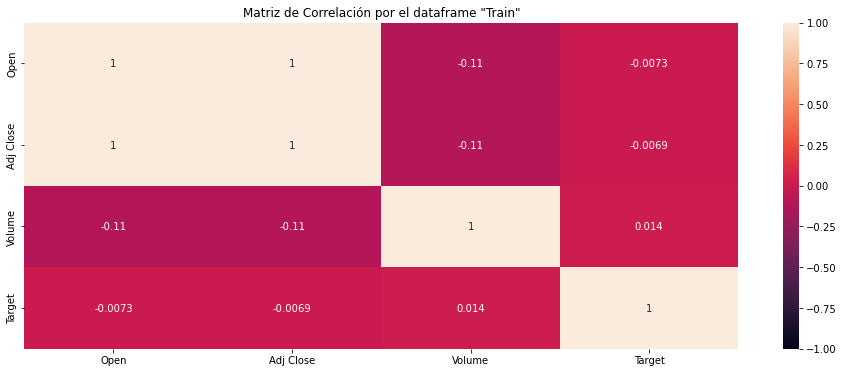

In [351]:
# Para ver las correlaciones entre los atributos:

plt.figure(figsize=(16, 6))
ax = plt.axes()

# Establecer el rango de valores que se mostrarán en el mapa de colores de -1 a 1
heatmap_df_train_raw = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True, ax = ax)

ax.set_title('Matriz de Correlación por el dataframe "Train"')

Por ahora el dataframe de train se mantiene así. A continuación habrá el tratamiento del dataframe con los tweets para poder incorporalos en los datos de train y test

### Tweets dataset

In [352]:
df_tweets_raw.head()

,tweetDate,handle,text
0,Sat Apr 09 14:47:45 +0000 2022,abelac62,"He hecho el repaso de todos los componentes del #IBEX35 y ahora me pongo con lo de La Chiqui. Si mañana tengo tiempo, publicaré algún activo interesante del mercado europeo y americano. Buen fin de semana."
1,Thu Apr 07 19:14:36 +0000 2022,LluisPerarnau,"Els projectes que han presentat les empreses del #Ibex35 als fons #NextGenerationEU: \nEndesa 110 projectes, 19.000 M €\nIberdrola 150 projectes, 21.000 M\nNaturgy 13.000 M\nACS 4.500 M\n...i així fins a sumar 100.000 M € per als grups oligàrquics de sempre."
2,Mon Apr 04 16:48:45 +0000 2022,Pegaso121080,"Por si no lo has visto, o no lo encuentras en búsquedas que suele pasar 🤔\n#Analisis y niveles del #Ibex35 y varias #Acciones en #Youtube \n#Ezentis #AedasHomes #LLeidanet #Merlinpropertis #BBVA y otras muchas en el canal 🧐\n🙏Espero que guste y/o ayude 🔄\nhttps://t.co/6yqA0TbRJY"
3,Tue Apr 05 07:23:16 +0000 2022,zonavalue,"📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 🔼 +0,10% (8.527,8 puntos)\n\nMayores subidas\n#Aena 🔼+1,40%\n#SiemensGamesa 🔼+1,07%\n#Cellnex 🔼+0,86% https://t.co/LxHqCPzPtP"
4,Thu Mar 31 16:07:43 +0000 2022,EPeconomia,"El #Ibex35 retrocede un 0,4% en marzo y un 3,08% en el primer trimestre de 2022\nhttps://t.co/wSm71JLkOr https://t.co/fttYtU1p0k"


In [353]:
df_tweets_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9801 entries, 0 to 9800
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweetDate  9799 non-null   object
 1   handle     9798 non-null   object
 2   text       9797 non-null   object
dtypes: object(3)
memory usage: 229.8+ KB


In [354]:
# para comprobar si existen fechas únicas o repetidas

df_tweets_raw['tweetDate'].nunique()

9780

In [355]:
# Comprobando que no existen duplicados:

duplicates(df_tweets_raw)

- Total entries: 9801  -Duplicated entries: 16  - Percentage: 0.16324864809713294 %


In [356]:
# Llamando todos los registros duplicados

df_tweets_raw[df_tweets_raw.duplicated(keep=False)]

,tweetDate,handle,text
104,Thu Feb 10 10:01:53 +0000 2022,EnBolsa_,Continuamos con el análisis de empresas del #IBEX35🇪🇸\n\nHoy avanzamos con otras 5\n\n➡#Amadeus\n➡#Arcelormittal\n➡#Caixabank\n➡#Bankinter\n➡#BBVA\n\nPara ver en directo:👇\nhttps://t.co/eg7XSAySBz\n#trading https://t.co/9bcqNCOaXs
126,Thu Feb 10 10:01:53 +0000 2022,EnBolsa_,Continuamos con el análisis de empresas del #IBEX35🇪🇸\n\nHoy avanzamos con otras 5\n\n➡#Amadeus\n➡#Arcelormittal\n➡#Caixabank\n➡#Bankinter\n➡#BBVA\n\nPara ver en directo:👇\nhttps://t.co/eg7XSAySBz\n#trading https://t.co/9bcqNCOaXs
752,Tue Jun 01 12:49:20 +0000 2021,FundacionHaz,"El 8 de junio presentaremos los resultados del VII informe de #Responsabilidadfiscal del #IBEX35, que este año analiza también la diligencia e independencia de los comités de #auditoría. #RSC #transparencia #impuestos #paraísosfiscales #blanqueo https://t.co/r5ZGiENoZS https://t.co/q57njVmL6j"
771,Tue Jun 01 12:49:20 +0000 2021,FundacionHaz,"El 8 de junio presentaremos los resultados del VII informe de #Responsabilidadfiscal del #IBEX35, que este año analiza también la diligencia e independencia de los comités de #auditoría. #RSC #transparencia #impuestos #paraísosfiscales #blanqueo https://t.co/r5ZGiENoZS https://t.co/q57njVmL6j"
1330,Fri Jan 08 17:40:57 +0000 2021,wethetraders,#Ibex35 #Ibex #trading https://t.co/3kJ1Nkvd6K
1336,Fri Dec 11 20:05:00 +0000 2020,VictorG_bolsa,"$GRF se ha pasado del 61,8% del ultimo impulso pero ojo que ese doble apoyo en ese soporte puede dar luegar a doble suelo si supera 26,75€, primero va a tener que batir la media de 30 y 200\n\n#ibex35 #españa #covid19 #trading #acciones #europa #eurostoxx50 https://t.co/979siOtaxP"
1368,Fri Jan 08 17:40:57 +0000 2021,wethetraders,#Ibex35 #Ibex #trading https://t.co/3kJ1Nkvd6K
1478,Fri Dec 11 20:05:00 +0000 2020,VictorG_bolsa,"$GRF se ha pasado del 61,8% del ultimo impulso pero ojo que ese doble apoyo en ese soporte puede dar luegar a doble suelo si supera 26,75€, primero va a tener que batir la media de 30 y 200\n\n#ibex35 #españa #covid19 #trading #acciones #europa #eurostoxx50 https://t.co/979siOtaxP"
1829,Tue Sep 29 08:11:47 +0000 2020,davidgtrading,"#Telefónica ha hecho lo primero que le pedíamos, un suelo en el nivel. A ver si quiere dar un rebote.\n\n#Tef #ibex35 https://t.co/yXjeeG3o67"
1867,Tue Sep 29 08:11:47 +0000 2020,davidgtrading,"#Telefónica ha hecho lo primero que le pedíamos, un suelo en el nivel. A ver si quiere dar un rebote.\n\n#Tef #ibex35 https://t.co/yXjeeG3o67"


In [357]:
# Eliminando los registros donde text = NaN

df_tweets_raw.dropna(subset = ["text"], inplace=True)


# Eliminando los registros duplicados, manteniendo el primero
df_tweets_raw.drop_duplicates(keep='first', inplace=True)

In [358]:
# Comprobando que ya no existen duplicados:

duplicates(df_tweets_raw)

- Total entries: 9782  -Duplicated entries: 0  - Percentage: 0.0 %


In [359]:
df_tweets_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9782 entries, 0 to 9800
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweetDate  9782 non-null   object
 1   handle     9782 non-null   object
 2   text       9782 non-null   object
dtypes: object(3)
memory usage: 305.7+ KB


In [360]:
# Mirar por registros irregulares según la fecha

df_tweets_raw[~df_tweets_raw['tweetDate'].str.startswith(("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"))] 

,tweetDate,handle,text
6932,#Bolsa #IBEX35 https://t.co/2wBR9k3hHr,Working In Progress,https://twitter.com/placetrading/status/961681603817852929
8500,https://t.co/XxKoBXa3pC,underground73,https://twitter.com/underground_73/status/749536356142055424
9635,http://t.co/c0R79uUipa,Verónica del Carpio,https://twitter.com/veronicadelcarp/status/582070485292331008
9668,http://t.co/scHVpKEQ4P http://t.co/uJaCax1Y3H,карлос asenksiovic,https://twitter.com/karlitosway41/status/577538391098675200


In [361]:
# Mantener solo los registros que respetan el formato de fecha

df_tweets_raw = df_tweets_raw[df_tweets_raw['tweetDate'].str.startswith(("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"))] 

In [362]:
df_tweets_raw["tweetDate"] =  pd.to_datetime(df_tweets_raw["tweetDate"])
df_tweets_raw["Date"] = df_tweets_raw["tweetDate"].dt.date


In [363]:
df_tweets_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9778 entries, 0 to 9800
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   tweetDate  9778 non-null   datetime64[ns, UTC]
 1   handle     9778 non-null   object             
 2   text       9778 non-null   object             
 3   Date       9778 non-null   object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 382.0+ KB


In [364]:
df_tweets_raw.head(15)

,tweetDate,handle,text,Date
0,2022-04-09 14:47:45+00:00,abelac62,"He hecho el repaso de todos los componentes del #IBEX35 y ahora me pongo con lo de La Chiqui. Si mañana tengo tiempo, publicaré algún activo interesante del mercado europeo y americano. Buen fin de semana.",2022-04-09
1,2022-04-07 19:14:36+00:00,LluisPerarnau,"Els projectes que han presentat les empreses del #Ibex35 als fons #NextGenerationEU: \nEndesa 110 projectes, 19.000 M €\nIberdrola 150 projectes, 21.000 M\nNaturgy 13.000 M\nACS 4.500 M\n...i així fins a sumar 100.000 M € per als grups oligàrquics de sempre.",2022-04-07
2,2022-04-04 16:48:45+00:00,Pegaso121080,"Por si no lo has visto, o no lo encuentras en búsquedas que suele pasar 🤔\n#Analisis y niveles del #Ibex35 y varias #Acciones en #Youtube \n#Ezentis #AedasHomes #LLeidanet #Merlinpropertis #BBVA y otras muchas en el canal 🧐\n🙏Espero que guste y/o ayude 🔄\nhttps://t.co/6yqA0TbRJY",2022-04-04
3,2022-04-05 07:23:16+00:00,zonavalue,"📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 🔼 +0,10% (8.527,8 puntos)\n\nMayores subidas\n#Aena 🔼+1,40%\n#SiemensGamesa 🔼+1,07%\n#Cellnex 🔼+0,86% https://t.co/LxHqCPzPtP",2022-04-05
4,2022-03-31 16:07:43+00:00,EPeconomia,"El #Ibex35 retrocede un 0,4% en marzo y un 3,08% en el primer trimestre de 2022\nhttps://t.co/wSm71JLkOr https://t.co/fttYtU1p0k",2022-03-31
5,2022-04-08 07:44:03+00:00,IndraCompany,Repetimos un año más como la mejor compañía del #Ibex35 en la que trabajar y la segunda en España en el #LinkedInTopCompanies 2022. \nVía @CincoDiascom https://t.co/6J2d60quFW,2022-04-08
6,2022-04-05 20:30:47+00:00,Bolsacarlosmari,"#Ibex35 se agota el margen para subir, cuidado que el resto de los mercados tienen señales de caídas como así han empezado hoy. https://t.co/Q72aXubaG0",2022-04-05
7,2022-04-08 18:15:19+00:00,Bolsacarlosmari,"#Ibex35 con el sentimiento negativo que hay, los mercados no caen y al menos, el nuestro tiene margen para subir, velas semanales. https://t.co/ZEq7L60L7k",2022-04-08
8,2022-03-31 14:57:52+00:00,CAPITALRADIOB,🔴 ANÁLISIS | También hemos dejado un hueco a la última hora del #IBEX35\n\n➡️ Con @juanestevee de @kaumarkets \n\n 🎙 Aquí te dejamos su análisis 👉 https://t.co/QiGi6vTkMA https://t.co/10rUIyXJt8,2022-03-31
9,2022-03-16 17:39:15+00:00,Tanyada_Ed,"🌿 ""Dels FLA als Next Genration: Recrudescència de la recentralització estatal contra els Països Catalans"" altre cop de la mà d'@ivallets, per entendre en profunditat el paper dels fons en la reestructuració del capitalisme i el centralisme.",2022-03-16


In [365]:
# Quitando las columnas "tweetDate" y "handle"

df_tweets_raw = df_tweets_raw.drop(['tweetDate', 'handle'], axis=1)

In [366]:
# Quitando los acentos

lista = []
for tweet in df_tweets_raw['text']:
    x = remove_accents(tweet)
    y = x.decode()
    lista.append(y)

In [367]:
lista

['He hecho el repaso de todos los componentes del #IBEX35 y ahora me pongo con lo de La Chiqui. Si manana tengo tiempo, publicare algun activo interesante del mercado europeo y americano. Buen fin de semana.',
 'Els projectes que han presentat les empreses del #Ibex35 als fons #NextGenerationEU: \nEndesa 110 projectes, 19.000 M \nIberdrola 150 projectes, 21.000 M\nNaturgy 13.000 M\nACS 4.500 M\n...i aixi fins a sumar 100.000 M  per als grups oligarquics de sempre.',
 'Por si no lo has visto, o no lo encuentras en busquedas que suele pasar \n#Analisis y niveles del #Ibex35 y varias #Acciones en #Youtube \n#Ezentis #AedasHomes #LLeidanet #Merlinpropertis #BBVA y otras muchas en el canal \nEspero que guste y/o ayude \nhttps://t.co/6yqA0TbRJY',
 ' #BOLSA: El #Ibex35 abre en  \n\n #Ibex35   +0,10% (8.527,8 puntos)\n\nMayores subidas\n#Aena +1,40%\n#SiemensGamesa +1,07%\n#Cellnex +0,86% https://t.co/LxHqCPzPtP',
 'El #Ibex35 retrocede un 0,4% en marzo y un 3,08% en el primer trimestre de 202

In [368]:
df_tweets_raw['clean'] = lista

In [369]:
df_tweets_raw

,text,Date,clean
0,"He hecho el repaso de todos los componentes del #IBEX35 y ahora me pongo con lo de La Chiqui. Si mañana tengo tiempo, publicaré algún activo interesante del mercado europeo y americano. Buen fin de semana.",2022-04-09,"He hecho el repaso de todos los componentes del #IBEX35 y ahora me pongo con lo de La Chiqui. Si manana tengo tiempo, publicare algun activo interesante del mercado europeo y americano. Buen fin de semana."
1,"Els projectes que han presentat les empreses del #Ibex35 als fons #NextGenerationEU: \nEndesa 110 projectes, 19.000 M €\nIberdrola 150 projectes, 21.000 M\nNaturgy 13.000 M\nACS 4.500 M\n...i així fins a sumar 100.000 M € per als grups oligàrquics de sempre.",2022-04-07,"Els projectes que han presentat les empreses del #Ibex35 als fons #NextGenerationEU: \nEndesa 110 projectes, 19.000 M \nIberdrola 150 projectes, 21.000 M\nNaturgy 13.000 M\nACS 4.500 M\n...i aixi fins a sumar 100.000 M per als grups oligarquics de sempre."
2,"Por si no lo has visto, o no lo encuentras en búsquedas que suele pasar 🤔\n#Analisis y niveles del #Ibex35 y varias #Acciones en #Youtube \n#Ezentis #AedasHomes #LLeidanet #Merlinpropertis #BBVA y otras muchas en el canal 🧐\n🙏Espero que guste y/o ayude 🔄\nhttps://t.co/6yqA0TbRJY",2022-04-04,"Por si no lo has visto, o no lo encuentras en busquedas que suele pasar \n#Analisis y niveles del #Ibex35 y varias #Acciones en #Youtube \n#Ezentis #AedasHomes #LLeidanet #Merlinpropertis #BBVA y otras muchas en el canal \nEspero que guste y/o ayude \nhttps://t.co/6yqA0TbRJY"
3,"📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 🔼 +0,10% (8.527,8 puntos)\n\nMayores subidas\n#Aena 🔼+1,40%\n#SiemensGamesa 🔼+1,07%\n#Cellnex 🔼+0,86% https://t.co/LxHqCPzPtP",2022-04-05,"#BOLSA: El #Ibex35 abre en \n\n #Ibex35 +0,10% (8.527,8 puntos)\n\nMayores subidas\n#Aena +1,40%\n#SiemensGamesa +1,07%\n#Cellnex +0,86% https://t.co/LxHqCPzPtP"
4,"El #Ibex35 retrocede un 0,4% en marzo y un 3,08% en el primer trimestre de 2022\nhttps://t.co/wSm71JLkOr https://t.co/fttYtU1p0k",2022-03-31,"El #Ibex35 retrocede un 0,4% en marzo y un 3,08% en el primer trimestre de 2022\nhttps://t.co/wSm71JLkOr https://t.co/fttYtU1p0k"
...,...,...,...
9796,"#Cierre | El #Ibex35 sube un 2,26% hasta los 10.115 puntos http://t.co/MFpBhvutv3",2015-01-08,"#Cierre | El #Ibex35 sube un 2,26% hasta los 10.115 puntos http://t.co/MFpBhvutv3"
9797,Un vistazo a los #Bluechips del #Ibex #Ibex35. Análisis del #BancoSantander #Inditex #Iberdrola y #Telefonica . http://t.co/GgYb65iAHX,2015-01-03,Un vistazo a los #Bluechips del #Ibex #Ibex35. Analisis del #BancoSantander #Inditex #Iberdrola y #Telefonica . http://t.co/GgYb65iAHX
9798,"Así comienza la #Bolsa en #2015 Ojo a los soportes en #Europa y especialmente #España con un #Ibex35 en -5,48% http://t.co/qUBAIgV3vX",2015-01-10,"Asi comienza la #Bolsa en #2015 Ojo a los soportes en #Europa y especialmente #Espana con un #Ibex35 en -5,48% http://t.co/qUBAIgV3vX"
9799,"Análisis del #BancoSantander #Santander #SAN tras el desplome del viernes.¿A tapar el gap de los 5,70€? #Ibex #Ibex35 http://t.co/h7MLbkcu6l",2015-01-10,"Analisis del #BancoSantander #Santander #SAN tras el desplome del viernes.A tapar el gap de los 5,70? #Ibex #Ibex35 http://t.co/h7MLbkcu6l"


In [370]:
df_tweets_raw['clean'] = df_tweets_raw['clean'].apply(lambda x: text_cleaning(x))
df_tweets_raw

,text,Date,clean
0,"He hecho el repaso de todos los componentes del #IBEX35 y ahora me pongo con lo de La Chiqui. Si mañana tengo tiempo, publicaré algún activo interesante del mercado europeo y americano. Buen fin de semana.",2022-04-09,he hecho el repaso de todos los componentes del ibex ahora pongo con lo de la chiqui si manana tengo tiempo publicare algun activo interesante del mercado europeo americano buen fin de semana
1,"Els projectes que han presentat les empreses del #Ibex35 als fons #NextGenerationEU: \nEndesa 110 projectes, 19.000 M €\nIberdrola 150 projectes, 21.000 M\nNaturgy 13.000 M\nACS 4.500 M\n...i així fins a sumar 100.000 M € per als grups oligàrquics de sempre.",2022-04-07,els projectes que han presentat les empreses del ibex als fons nextgenerationeu endesa projectes 9 m iberdrola projectes m naturgy m acs m i aixi fins sumar m per als grups oligarquics de sempre
2,"Por si no lo has visto, o no lo encuentras en búsquedas que suele pasar 🤔\n#Analisis y niveles del #Ibex35 y varias #Acciones en #Youtube \n#Ezentis #AedasHomes #LLeidanet #Merlinpropertis #BBVA y otras muchas en el canal 🧐\n🙏Espero que guste y/o ayude 🔄\nhttps://t.co/6yqA0TbRJY",2022-04-04,por si lo visto lo encuentras en busquedas que suele pasar analisis niveles del ibex varias acciones en youtube ezentis aedashomes lleidanet merlinpropertis bbva otras muchas en el canal espero que guste yo ayude
3,"📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 🔼 +0,10% (8.527,8 puntos)\n\nMayores subidas\n#Aena 🔼+1,40%\n#SiemensGamesa 🔼+1,07%\n#Cellnex 🔼+0,86% https://t.co/LxHqCPzPtP",2022-04-05,bolsa el ibex abre en ibex puntos mayores subidas aena siemensgamesa cellnex
4,"El #Ibex35 retrocede un 0,4% en marzo y un 3,08% en el primer trimestre de 2022\nhttps://t.co/wSm71JLkOr https://t.co/fttYtU1p0k",2022-03-31,el ibex retrocede un en marzo un en el primer trimestre de
...,...,...,...
9796,"#Cierre | El #Ibex35 sube un 2,26% hasta los 10.115 puntos http://t.co/MFpBhvutv3",2015-01-08,cierre el ibex sube un hasta los puntos
9797,Un vistazo a los #Bluechips del #Ibex #Ibex35. Análisis del #BancoSantander #Inditex #Iberdrola y #Telefonica . http://t.co/GgYb65iAHX,2015-01-03,un vistazo los bluechips del ibex ibex analisis del bancosantander inditex iberdrola telefonica
9798,"Así comienza la #Bolsa en #2015 Ojo a los soportes en #Europa y especialmente #España con un #Ibex35 en -5,48% http://t.co/qUBAIgV3vX",2015-01-10,asi comienza la bolsa en ojo los soportes en europa especialmente espana con un ibex en -
9799,"Análisis del #BancoSantander #Santander #SAN tras el desplome del viernes.¿A tapar el gap de los 5,70€? #Ibex #Ibex35 http://t.co/h7MLbkcu6l",2015-01-10,analisis del bancosantander santander san tras el desplome del viernesa tapar el gap de los ibex ibex


El propósito con el siguiente código era traducir los tweets limpios y medir su subjetividad y polaridad. Sin embargo he tenido muchos problemas en la ora del NLP y del análisis de sentiniento, ya que se ve que java no está configurada correctamente en mi caso. Como resultado, no puedo implementar soluciones simples y pierdo mucho tiempo en hacer ciertas tareas

In [371]:
"""df_tweets_raw['clean'] = df_tweets_raw['clean'].apply(lambda x: str(x))
df_tweets_raw['blob_en'] = df_tweets_raw['clean'].apply(lambda x: TextBlob(x).translate(to="en"))
df_tweets_raw['polarity'] = df_tweets_raw['analyze_sentiment'].apply(getSubjectivity)
df_tweets_raw['subjectivity'] = df_tweets_raw['blob_en'].apply(getPolarity)
df_tweets_raw"""

'df_tweets_raw[\'clean\'] = df_tweets_raw[\'clean\'].apply(lambda x: str(x))\ndf_tweets_raw[\'blob_en\'] = df_tweets_raw[\'clean\'].apply(lambda x: TextBlob(x).translate(to="en"))\ndf_tweets_raw[\'polarity\'] = df_tweets_raw[\'analyze_sentiment\'].apply(getSubjectivity)\ndf_tweets_raw[\'subjectivity\'] = df_tweets_raw[\'blob_en\'].apply(getPolarity)\ndf_tweets_raw'

Y el código a continuación iba a ser incluido por si introduciera los strings

In [372]:
"""le = preprocessing.LabelEncoder()
for column_name in df_train_clean.columns:
    if df_train_clean[column_name].dtype == object:
        modellb = le.fit(df_train_clean[column_name])
        df_train_clean[column_name] = modellb.transform(df_train_clean[column_name])
    else:
        pass
"""

'le = preprocessing.LabelEncoder()\nfor column_name in df_train_clean.columns:\n    if df_train_clean[column_name].dtype == object:\n        modellb = le.fit(df_train_clean[column_name])\n        df_train_clean[column_name] = modellb.transform(df_train_clean[column_name])\n    else:\n        pass\n'

Se realizará el mismo proceso de limpieza para que el dataframe tenga la misma estructura que lo de train

## Creación del modelo de predicción: regresión logistica

### Modelo con todas las variables numericas

### Preparación

In [373]:
df_train_raw = df_train_raw.drop(['Date'], axis=1)

In [374]:
# Primero miramos si los datos están balanceados o no

print(df_train_raw['Target'].value_counts())

1    2504
0    2324
Name: Target, dtype: int64


In [375]:
# Aislando el atributo "Target" del dataframe como la variable dependiente del modelo

target = df_train_raw.pop('Target')

In [376]:
X_train, X_test, y_train, y_test = train_test_split(df_train_raw, target, test_size=0.3, random_state=858)

In [377]:
print(X_train.shape)     # el esquema de las variables independientes

(3379, 6)


In [378]:
# Verificando la cantidad de registros entre entrenar y probar después de la división:

print("Training Data:", Counter(y_train))
print("Testing Data:", Counter(y_test))

Training Data: Counter({1: 1775, 0: 1604})
Testing Data: Counter({1: 729, 0: 720})


In [379]:
# Escalando los datos a las variables independientes:

model_normalization = StandardScaler().fit(X_train)
features = model_normalization.transform(X_train)
features

array([[ 0.55223033,  0.54056183,  0.52495793,  0.57557742,  0.57557687,
         1.39990106],
       [-0.19851105, -0.22462132, -0.16177808, -0.18888274, -0.1888836 ,
        -0.83746472],
       [-1.75109603, -1.66708787, -1.71880827, -1.64420227, -1.64420295,
        -0.83714031],
       ...,
       [-0.50478328, -0.52087481, -0.48335971, -0.50958287, -0.50958359,
         0.3480905 ],
       [-0.62874948, -0.59994081, -0.59609208, -0.58797424, -0.58797503,
        -0.83778459],
       [ 0.62866384,  0.59307708,  0.56117952,  0.53809274,  0.5380974 ,
         2.19868068]])

##### Train

In [380]:
lr1 = LogisticRegression()
lr1.fit(X_train, y_train)

LogisticRegression()

In [381]:
# Train score

lr1.score(X_train,y_train)

0.5253033441846701

In [382]:
X_test_norm = model_normalization.transform(X_test)

In [383]:
# Aplicando el modelo entrenado:

test_predictions1 = lr1.predict(X_test_norm)
test_predictions1

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

In [384]:
# Obteniendo las probabilidades de clasificación:

probability1 = lr1.predict_proba(X_test)
probability1

array([[0.49841058, 0.50158942],
       [0.47576014, 0.52423986],
       [0.47494616, 0.52505384],
       ...,
       [0.43318894, 0.56681106],
       [0.47141653, 0.52858347],
       [0.49999067, 0.50000933]])

##### Evaluación

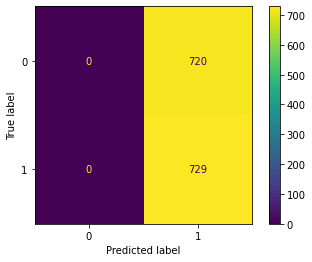

In [385]:
# Confusion Matrix:

CA1 = metrics.plot_confusion_matrix(lr1,X_test,y_test)

In [386]:
# Mirando la bondad del modelo

CR1 = classification_report(y_test, test_predictions1)

print ('\033[1m' + 'Classification Report: Logistic Regession','\033[0m')
print (' ')
print(CR1)

Classification Report: Logistic Regession 
 
              precision    recall  f1-score   support

           0       0.50      0.57      0.53       720
           1       0.51      0.44      0.47       729

    accuracy                           0.50      1449
   macro avg       0.50      0.50      0.50      1449
weighted avg       0.50      0.50      0.50      1449



In [387]:
# The weight of each atribute for the predictions:

coefs1=lr1.coef_
print(coefs1)
print(X_train.columns)

[[5.40443446e-14 5.44513083e-14 5.36926374e-14 5.43007413e-14
  5.43006887e-14 5.55116083e-10]]
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


### El mismo modelo sin las variables 'High', 'Low', 'Close'

### Preparación

In [388]:
df_train = df_train.drop(['Date'], axis=1)

In [389]:
X_train, X_test, y_train, y_test = train_test_split(df_train, target, test_size=0.3, random_state=858)

In [390]:
print(X_train.shape)     # el esquema de las variables independientes

(3379, 4)


In [391]:
# Verificando la cantidad de registros entre entrenar y probar después de la división:

print("Training Data:", Counter(y_train))
print("Testing Data:", Counter(y_test))

Training Data: Counter({1: 1775, 0: 1604})
Testing Data: Counter({1: 729, 0: 720})


In [392]:
# Escalando los datos a las variables independientes:

model_normalization = StandardScaler().fit(X_train)
features = model_normalization.transform(X_train)
features

array([[ 0.55223033,  0.57557687,  1.39990106,  0.95061137],
       [-0.19851105, -0.1888836 , -0.83746472, -1.0519546 ],
       [-1.75109603, -1.64420295, -0.83714031, -1.0519546 ],
       ...,
       [-0.50478328, -0.50958359,  0.3480905 ,  0.95061137],
       [-0.62874948, -0.58797503, -0.83778459,  0.95061137],
       [ 0.62866384,  0.5380974 ,  2.19868068,  0.95061137]])

##### Train

In [393]:
lr2 = LogisticRegression()
lr2.fit(X_train, y_train)

LogisticRegression()

In [394]:
# Train score

lr2.score(X_train,y_train)

0.5253033441846701

In [395]:
X_test_norm = model_normalization.transform(X_test)

In [396]:
# Aplicando el modelo entrenado:

test_predictions2 = lr2.predict(X_test_norm)
test_predictions2

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

In [397]:
# Obtaining the probabilities according to which the model is classifying:

probability2 = lr2.predict_proba(X_test)
probability2

array([[0.49841058, 0.50158942],
       [0.47576014, 0.52423986],
       [0.47494616, 0.52505384],
       ...,
       [0.43318895, 0.56681105],
       [0.47141654, 0.52858346],
       [0.49999067, 0.50000933]])

##### Evaluación

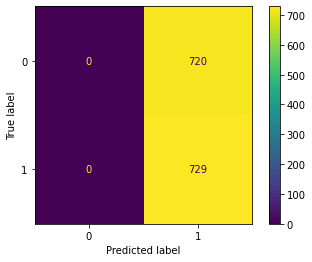

In [398]:
CA2 = metrics.plot_confusion_matrix(lr2,X_test,y_test)

In [399]:
CR2 = classification_report(y_test, test_predictions2)

print ('\033[1m' + 'Classification Report: Logistic Regession','\033[0m')
print (' ')
print(CR1)

Classification Report: Logistic Regession 
 
              precision    recall  f1-score   support

           0       0.50      0.57      0.53       720
           1       0.51      0.44      0.47       729

    accuracy                           0.50      1449
   macro avg       0.50      0.50      0.50      1449
weighted avg       0.50      0.50      0.50      1449



In [400]:
coefs2=lr2.coef_
print(coefs1)
print(X_train.columns)

[[5.40443446e-14 5.44513083e-14 5.36926374e-14 5.43007413e-14
  5.43006887e-14 5.55116083e-10]]
Index(['Open', 'Adj Close', 'Volume', 'Target'], dtype='object')


## Creación de una red neuronal como modelo de predicción

In [401]:
# Pasamos el dataframe a numpy array para poder entrenar la red neuronal:

model_normalization = StandardScaler().fit(df_train_raw)
features = model_normalization.transform(df_train_raw)
features

array([[ 0.55623454,  0.54140252,  0.56681382,  0.53399333,  0.53399273,
        -0.79164232],
       [ 0.53261286,  0.50110968,  0.51310643,  0.47659707,  0.4765964 ,
        -0.77775209],
       [ 0.47913199,  0.50012932,  0.52255779,  0.49093391,  0.49093326,
        -0.7832719 ],
       ...,
       [-0.25859659, -0.29165733, -0.26001693, -0.27107384, -0.27107001,
         0.834539  ],
       [-0.3112425 , -0.34469484, -0.30816215, -0.32572031, -0.32571653,
         0.30166071],
       [-0.30751034, -0.31601934, -0.26927215, -0.28776731, -0.28776349,
        -0.0611278 ]])

### Dividir los datos de entrenamiento en Train & Test

In [402]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=58)

In [403]:
print(X_train.shape)     

# el shape de las variables independientes del train, que nos ayudará a escoger la cantidad de nodos por la capa de entrada

(3379, 6)


In [404]:
# Comprobando la cantidad de registros después del split:

print("Datos de entrenamiento:", Counter(y_train))
print("Datos de testeo:", Counter(y_test))

Datos de entrenamiento: Counter({1: 1761, 0: 1618})
Datos de testeo: Counter({1: 743, 0: 706})


### Creación y entrenamiento de la red neuronal

In [405]:
tf.keras.backend.clear_session()    # para poder entrenar la red de nuevo sin aprovechar intentos anteriores
                                    # (hay que ejecutar el comando cada vez que queramos entrenar la red neuronal desde el principio)
tf.random.set_seed(51)              # definiendo el seed para poder replicar el modelo
np.random.seed(51)                  # definiendo el seed para poder replicar el modelo

In [406]:
model = Sequential()     
#Se monta una pila lineal de capas que especificamos a continuación

model.add(Dense(4, input_shape=(6,), activation='ReLU'))      # Capa de entrada
model.add(Dense(2, activation='ReLU'))                         # Capa 1
model.add(Dense(1, activation='sigmoid'))                      # Capa de salida

model.compile(Adam(lr=0.02), 'binary_crossentropy', metrics=['accuracy'])

#Configuración del modelo a entrenar. 
# Optimizador:Adam   binary_crossentropy: función de coste que necesitamos en un problema binario clasificatorio supervisado

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [407]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 28        
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [408]:
#Entrenando el modelo con X_train y_train utilizando "fit", con 50 iteraciones

hist = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=50, verbose=1, batch_size=500)

Epoch 1/50
7/7 [==============================] - 2s 229ms/step - loss: 0.6957 - accuracy: 0.5007 - val_loss: 0.6923 - val_accuracy: 0.5135
Epoch 2/50
7/7 [==============================] - 0s 10ms/step - loss: 0.6924 - accuracy: 0.5215 - val_loss: 0.6937 - val_accuracy: 0.5128
Epoch 3/50
7/7 [==============================] - 0s 12ms/step - loss: 0.6918 - accuracy: 0.5218 - val_loss: 0.6929 - val_accuracy: 0.5072
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.6916 - accuracy: 0.5209 - val_loss: 0.6928 - val_accuracy: 0.5135
Epoch 5/50
7/7 [==============================] - 0s 12ms/step - loss: 0.6913 - accuracy: 0.5209 - val_loss: 0.6929 - val_accuracy: 0.5135
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 0.6909 - accuracy: 0.5212 - val_loss: 0.6926 - val_accuracy: 0.5141
Epoch 7/50
7/7 [==============================] - 0s 13ms/step - loss: 0.6911 - accuracy: 0.5135 - val_loss: 0.6924 - val_accuracy: 0.5176
Epoch 8/50
7/7 [==========

In [409]:
# Evaluando el modelo con X_test y_test

results = model.evaluate(X_test, y_test)  

46/46 [==============================] - 0s 2ms/step - loss: 0.6914 - accuracy: 0.5238


In [410]:
print("Loss value & accuracy value respectivamente:", results)

Loss value & accuracy value respectivamente: [0.6913758516311646, 0.523809552192688]


In [411]:
hist.history

{'loss': [0.6956999897956848,
  0.6924119591712952,
  0.6918141841888428,
  0.6916442513465881,
  0.6912968754768372,
  0.6908695697784424,
  0.6911001801490784,
  0.690252423286438,
  0.6904662251472473,
  0.6899825930595398,
  0.690169095993042,
  0.6899499893188477,
  0.6901219487190247,
  0.6896001696586609,
  0.6900516748428345,
  0.6901520490646362,
  0.6901427507400513,
  0.6899387240409851,
  0.689841091632843,
  0.6896161437034607,
  0.6896390914916992,
  0.6901315450668335,
  0.6902351975440979,
  0.6903827786445618,
  0.6894169449806213,
  0.6893718838691711,
  0.6893959641456604,
  0.6895318627357483,
  0.689469575881958,
  0.6898689866065979,
  0.6894000768661499,
  0.6890377998352051,
  0.6905961632728577,
  0.6891319155693054,
  0.6902987957000732,
  0.6892958283424377,
  0.6890071034431458,
  0.6894605159759521,
  0.688663125038147,
  0.6890536546707153,
  0.689326822757721,
  0.6887642741203308,
  0.6890819668769836,
  0.6901986002922058,
  0.6899508237838745,
  0.6892

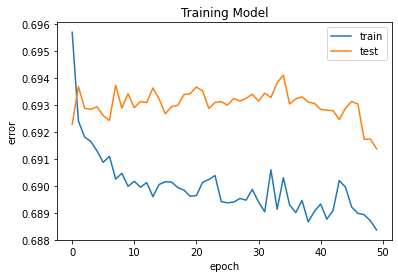

In [412]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')

plt.title('Training Model')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend();

### Métricas de evaluación

In [413]:
# Predicción
model_prediction = model.predict(X_test)

#Con valores > 0.5 se define clase 1 => threshold
pred_train = (model.predict(X_train) > 0.5)
pred_test = (model.predict(X_test) > 0.5)


# Comprobar la bondad del modelo
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.52      0.36      0.42       706
           1       0.53      0.68      0.60       743

    accuracy                           0.52      1449
   macro avg       0.52      0.52      0.51      1449
weighted avg       0.52      0.52      0.51      1449



In [414]:
print("Matriz de confusión por la red neuronal:")
print("\n")
print(confusion_matrix(y_test, pred_test))

Matriz de confusión por la red neuronal:


[[252 454]
 [236 507]]


### El mismo modelo sin las variables 'High', 'Low', 'Close'

In [415]:
# Pasamos el dataframe a numpy array para poder entrenar la red neuronal:

model_normalization = StandardScaler().fit(df_train)
features = model_normalization.transform(df_train)
features

array([[ 0.55623454,  0.53399273, -0.79164232, -1.03800418],
       [ 0.53261286,  0.4765964 , -0.77775209, -1.03800418],
       [ 0.47913199,  0.49093326, -0.7832719 , -1.03800418],
       ...,
       [-0.25859659, -0.27107001,  0.834539  , -1.03800418],
       [-0.3112425 , -0.32571653,  0.30166071, -1.03800418],
       [-0.30751034, -0.28776349, -0.0611278 , -1.03800418]])

### Dividir los datos de entrenamiento en Train & Test

In [416]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=58)

In [417]:
print(X_train.shape)     

# el shape de las variables independientes del train, que nos ayudará a escoger la cantidad de nodos por la capa de entrada

(3379, 4)


In [418]:
# Comprobando la cantidad de registros después del split:

print("Datos de entrenamiento:", Counter(y_train))
print("Datos de testeo:", Counter(y_test))

Datos de entrenamiento: Counter({1: 1761, 0: 1618})
Datos de testeo: Counter({1: 743, 0: 706})


### Creación y entrenamiento de la red neuronal

In [419]:
tf.keras.backend.clear_session()    # para poder entrenar la red de nuevo sin aprovechar intentos anteriores
                                    # (hay que ejecutar el comando cada vez que queramos entrenar la red neuronal desde el principio)
tf.random.set_seed(51)              # definiendo el seed para poder replicar el modelo
np.random.seed(51)                  # definiendo el seed para poder replicar el modelo

In [420]:
model2 = Sequential()     
#Se monta una pila lineal de capas que especificamos a continuación

model2.add(Dense(4, input_shape=(4,), activation='ReLU'))      # Capa de entrada
model2.add(Dense(2, activation='ReLU'))                         # Capa 1
model2.add(Dense(1, activation='sigmoid'))                      # Capa de salida

model2.compile(Adam(lr=0.02), 'binary_crossentropy', metrics=['accuracy'])

#Configuración del modelo a entrenar. 
# Optimizador:Adam   binary_crossentropy: función de coste que necesitamos en un problema binario clasificatorio supervisado

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [421]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [422]:
#Entrenando el modelo con X_train y_train utilizando "fit", con 50 iteraciones

hist2 = model2.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=50, verbose=1, batch_size=500)

Epoch 1/50
7/7 [==============================] - 1s 45ms/step - loss: 0.6659 - accuracy: 0.5809 - val_loss: 0.5804 - val_accuracy: 0.6674
Epoch 2/50
7/7 [==============================] - 0s 11ms/step - loss: 0.5350 - accuracy: 0.7076 - val_loss: 0.4552 - val_accuracy: 0.8868
Epoch 3/50
7/7 [==============================] - 0s 11ms/step - loss: 0.3828 - accuracy: 0.9506 - val_loss: 0.2729 - val_accuracy: 0.9917
Epoch 4/50
7/7 [==============================] - 0s 11ms/step - loss: 0.1994 - accuracy: 0.9994 - val_loss: 0.1126 - val_accuracy: 1.0000
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0763 - accuracy: 1.0000 - val_loss: 0.0376 - val_accuracy: 1.0000
Epoch 6/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0253 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 7/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 8/50
7/7 [===========

In [423]:
# Evaluando el modelo con X_test y_test

results2 = model2.evaluate(X_test, y_test)  

46/46 [==============================] - 0s 2ms/step - loss: 1.3025e-04 - accuracy: 1.0000


In [424]:
print("Loss value & accuracy value respectivamente:", results)

Loss value & accuracy value respectivamente: [0.6913758516311646, 0.523809552192688]


In [425]:
hist2.history

{'loss': [0.6659119725227356,
  0.5350330471992493,
  0.38275280594825745,
  0.19938518106937408,
  0.07633528858423233,
  0.025252219289541245,
  0.009107120335102081,
  0.004101959057152271,
  0.002366011729463935,
  0.0016390635864809155,
  0.0012774878414347768,
  0.0010753492824733257,
  0.0009414156666025519,
  0.0008445920539088547,
  0.0007696656393818557,
  0.0007081470103003085,
  0.0006542010814882815,
  0.0006082955515012145,
  0.0005667247460223734,
  0.0005296606104820967,
  0.0004960346268489957,
  0.00046553253196179867,
  0.0004380497266538441,
  0.0004127548018004745,
  0.0003895186528097838,
  0.00036829267628490925,
  0.0003487579815555364,
  0.000330614042468369,
  0.0003139518667012453,
  0.0002985809987876564,
  0.0002841632813215256,
  0.00027094074175693095,
  0.0002584513567853719,
  0.0002468874445185065,
  0.0002361650695092976,
  0.00022609006555285305,
  0.00021661979553755373,
  0.00020773646247107536,
  0.00019941192294936627,
  0.000191557192010805,
  0

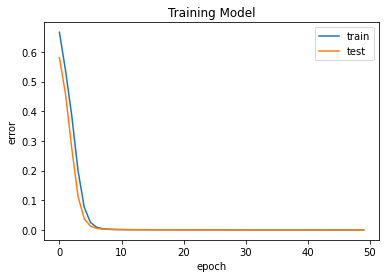

In [426]:
plt.plot(hist2.history['loss'], label='train')
plt.plot(hist2.history['val_loss'], label='test')

plt.title('Training Model')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend();

### Métricas de evaluación

In [427]:
# Predicción
model_prediction = model2.predict(X_test)

#Con valores > 0.5 se define clase 1 => threshold
pred_train = (model2.predict(X_train) > 0.5)
pred_test = (model2.predict(X_test) > 0.5)


# Comprobar la bondad del modelo
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       706
           1       1.00      1.00      1.00       743

    accuracy                           1.00      1449
   macro avg       1.00      1.00      1.00      1449
weighted avg       1.00      1.00      1.00      1449



In [428]:
print(confusion_matrix(y_test, pred_test))

[[706   0]
 [  0 743]]


Los resultados anteriores indican sobreajuste a los datos de entrenamiento!

## Aplicación del modelo a los datos a predecir

### Test dataset

### Preparación del dataset

In [429]:
df_test_raw.info() 

# así podemos ver brevemente la cantidad de registros, la existencia de nulos y el tipo de los datos 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   test_index  726 non-null    int64  
 1   Date        726 non-null    object 
 2   Open        726 non-null    float64
 3   High        726 non-null    float64
 4   Low         726 non-null    float64
 5   Close       726 non-null    float64
 6   Adj Close   726 non-null    float64
 7   Volume      726 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 45.5+ KB


In [430]:
# Viendo solo 0 en los primeros registros por el atributo "Volume", vamos a ver si existen otros valores

columns_with_all_zeroes(df_test_raw)

Column ' test_index ' contains other values
Column ' Date ' contains other values
Column ' Open ' contains other values
Column ' High ' contains other values
Column ' Low ' contains other values
Column ' Close ' contains other values
Column ' Adj Close ' contains other values
Column ' Volume ' contains other values


Aunque la columna "volume" no tiene solo ceros, tener muchos registros con ese valor podría perjudicar el rendimiento del modelo. Por tanto, se va a contar la cantidad de registros donde el volumen de acciones negociadas es 0.

In [431]:
print("Cantidad de 0s en la columna 'Volume':", (df_test_raw['Volume'] == 0).sum())
print("Total de registros:", len(df_test_raw))

Cantidad de 0s en la columna 'Volume': 0
Total de registros: 726


In [432]:
df_test = df_test_raw.drop(['Date'], axis=1)

In [433]:
df_test.set_index('test_index', inplace=True)

In [434]:
# Pasamos el dataframe a numpy array para poder entrenar la red neuronal:

model_normalization = StandardScaler().fit(df_test)
features = model_normalization.transform(df_test)
features

array([[ 0.81991636,  0.80735497,  0.83254891,  0.83573305,  0.83573305,
        -0.49143826],
       [ 0.85596864,  0.8895162 ,  0.87805961,  0.85644895,  0.85644895,
         0.04021462],
       [ 0.87544109,  0.90667101,  0.93153716,  0.93055948,  0.93055948,
        -0.57111837],
       ...,
       [ 0.05681903,  0.18392066,  0.09554116,  0.24206772,  0.24206772,
         0.48442162],
       [ 0.20403055,  0.15728635,  0.19289235,  0.17116913,  0.17116913,
        -0.22903958],
       [ 0.1809972 ,  0.14701551,  0.12326154,  0.05429724,  0.05429724,
         0.11308059]])

### Predicciones

In [435]:
print(features.shape)     

# el shape de las variables independientes del train, que nos ayudará a escoger la cantidad de nodos por la capa de entrada

(726, 6)


In [436]:
tf.keras.backend.clear_session()    # para poder entrenar la red de nuevo sin aprovechar intentos anteriores
                                    # (hay que ejecutar el comando cada vez que queramos entrenar la red neuronal desde el principio)
tf.random.set_seed(51)              # definiendo el seed para poder replicar el modelo
np.random.seed(51)                  # definiendo el seed para poder replicar el modelo

In [437]:
model = Sequential()     
#Se monta una pila lineal de capas que especificamos a continuación

model.add(Dense(4, input_shape=(6,), activation='ReLU'))      # Capa de entrada
model.add(Dense(2, activation='ReLU'))                         # Capa 1
model.add(Dense(1, activation='sigmoid'))                      # Capa de salida

model.compile(Adam(lr=0.02), 'binary_crossentropy', metrics=['accuracy'])

#Configuración del modelo a entrenar. 
# Optimizador:Adam   binary_crossentropy: función de coste que necesitamos en un problema binario clasificatorio supervisado

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [438]:
# Predicción
prediction = model.predict(features)

In [439]:
prediction

array([[0.5       ],
       [0.48883402],
       [0.5       ],
       [0.50032455],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.45380306],
       [0.49889404],
       [0.4942108 ],
       [0.4514517 ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.4934861 ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.49852267],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.463713  ],
       [0.4859161 ],
       [0.5       ],
       [0.45524585],
       [0.5       ],
       [0.5002269 ],
       [0.48666057],
       [0.5       ],
       [0.5       ],
       [0.5       ],
       [0.5012404 ],
       [0.5  

In [440]:
df_predictions = pd.DataFrame(index=df_test.index)

In [441]:
df_predictions["Target"] = prediction

In [442]:
df_predictions

,Target
test_index,
6557,0.500000
6558,0.488834
6559,0.500000
6560,0.500325
6561,0.500000
...,...
7278,0.519044
7279,0.509146
7280,0.447955


In [444]:
df_predictions['Target'] = np.where(df_predictions['Target'] >= 0.5, 1, 0)

In [445]:
df_predictions

,Target
test_index,
6557,1
6558,0
6559,1
6560,1
6561,1
...,...
7278,1
7279,1
7280,0


In [446]:
# Guardar los resultados

df_predictions.to_csv("predictions.csv", index=True)
df_predictions.to_json('predictions.json')